In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

In [28]:
ts = '20241108-123515'

fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
df = pd.read_csv(fpath)
# drop nans
df.dropna(inplace=True)
fpath = os.path.join(DATA_DIR,'processed',f'training_acs_df_{ts}.csv')
df_acs = pd.read_csv(fpath)
df_acs.set_index('Fips',inplace=True,drop=True)
# standardize
df_acs = (df_acs-df_acs.mean()) / df_acs.std()

### <font color=blue> Transform target (and target-affecting) variables.

In [29]:
county_transform = [x for x in df.columns if x.startswith('True_county_inc_deaths')]
county_transform += ['Naive_proj_deaths','Naive_true_deaths']
for var in county_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.Pop * 100000, axis=1)
    
state_transform = ['Proj_state_inc_deaths','True_state_inc_deaths']
for var in state_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.State_pop * 100000, axis=1)
    
# display(df)
# add in census features
df = df.merge(df_acs,on='Fips')

_Choose base "predictive" attributes_

In [30]:
df.columns[:20]

Index(['Date', 'State_fips', 'Fips', 'Pop', 'State_pop', 'Ratio',
       'Proj_state_inc_deaths', 'True_state_inc_deaths',
       'True_county_cum_deaths', 'True_county_inc_deaths', 'Naive_proj_deaths',
       'Naive_true_deaths', 'True_county_inc_deaths_tm_4',
       'True_county_inc_deaths_tm_5', 'True_county_inc_deaths_tm_6',
       'True_county_inc_deaths_tm_7', 'True_county_inc_deaths_tm_8',
       'True_county_inc_deaths_tm_9', 'True_county_inc_deaths_tm_10',
       'True_county_inc_deaths_tm_11'],
      dtype='object')

In [31]:
BASE_PRED_COLS = [x for x in df.filter(regex='True_county_inc_deaths_tm_._x').columns]
display(BASE_PRED_COLS)

['True_county_inc_deaths_tm_4_x',
 'True_county_inc_deaths_tm_5_x',
 'True_county_inc_deaths_tm_6_x',
 'True_county_inc_deaths_tm_7_x',
 'True_county_inc_deaths_tm_8_x',
 'True_county_inc_deaths_tm_9_x']

In [43]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
random.seed(666)

from tqdm.notebook import tqdm

target_col = 'True_county_inc_deaths_x'

num_weeks_in_chunk = 4
num_runs = 20
alg = 'LinReg'

chunks = get_chunks(list(df.Date.unique()), num_weeks_in_chunk)
idc = random.sample(range(len(chunks)), num_runs)

test_dfs = []
models = {}

for i,idx in tqdm(enumerate(idc), total=len(idc)):
    
    df_train, df_test = get_date_chunked_splits(df, chunks, idx)
    
#     display(df_test.head())
        
    df_test[f'Run'] = i

#     for main_pred_col in ['True_state_inc_deaths_x','Proj_state_inc_deaths_x']:
    for main_pred_col in ['Naive_true_deaths_x','Naive_proj_deaths_x']:
        
        feats =  [main_pred_col] + BASE_PRED_COLS + [x for x in df_acs.columns] 
        X_train = df_train[feats]
        y_train = df_train[target_col]

        X_test = df_test[feats]
#         display(X_test[:5])
#         print('hi')

        reg = LinearRegression().fit(X_train, y_train)

        df_test[f'{alg}_({main_pred_col})'] = reg.predict(X_test)
        

    test_dfs.append(df_test)
    models[i] = reg
    
df_res = pd.concat(test_dfs)
df_res.drop(df_acs.columns,axis=1,inplace=True)

print(f'Training set size: {len(X_train)}\nTest set size: {len(X_test)}')

  0%|          | 0/20 [00:00<?, ?it/s]

Training set size: 8400
Test set size: 400


In [44]:
X_train.columns

Index(['Naive_proj_deaths_x', 'True_county_inc_deaths_tm_4_x',
       'True_county_inc_deaths_tm_5_x', 'True_county_inc_deaths_tm_6_x',
       'True_county_inc_deaths_tm_7_x', 'True_county_inc_deaths_tm_8_x',
       'True_county_inc_deaths_tm_9_x', 'POP', 'POP_M', 'POP_F',
       ...
       'HU_x15', 'HU_UIS01D', 'HU_UIS01A', 'HU_UIS02', 'HU_UIS0304',
       'HU_UIS0509', 'HU_UIS1019', 'HU_UIS2049', 'HU_UIS50P', 'HU_UISOTHER'],
      dtype='object', length=194)

In [49]:
df_res

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,...,True_county_inc_deaths_tm_9_x,True_county_inc_deaths_tm_10_x,True_county_inc_deaths_tm_11_x,Naive_proj_deaths_x,Naive_true_deaths_x,Proj_state_inc_deaths_x,True_state_inc_deaths_x,Run,LinReg_(Naive_true_deaths_x),LinReg_(Naive_proj_deaths_x)
56,20211002,37,37001,169185,10367022,0.016320,486.0,499.0,310.0,0.0,...,0.591069,0.591069,0.591069,5.279011,5.404409,4.697588,4.822986,0,6.728933,7.867736
57,20211009,37,37001,169185,10367022,0.016320,471.0,496.0,323.0,13.0,...,0.591069,0.591069,0.591069,5.134322,5.375471,4.552899,4.794048,0,6.749044,7.720275
58,20211016,37,37001,169185,10367022,0.016320,451.0,351.0,332.0,9.0,...,1.182138,0.591069,0.591069,4.941402,3.976805,4.359979,3.395382,0,4.848455,7.321838
59,20211023,37,37001,169185,10367022,0.016320,336.0,311.0,334.0,2.0,...,1.182138,1.182138,0.591069,3.832115,3.590966,3.250692,3.009543,0,4.412496,6.240783
144,20211002,37,37003,36491,10367022,0.003520,486.0,499.0,111.0,8.0,...,2.740402,5.480803,2.740402,7.428344,7.553742,4.697588,4.822986,0,10.204298,9.117208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8659,20210508,37,37197,37198,10367022,0.003588,130.0,126.0,48.0,1.0,...,5.376633,2.688317,10.753266,3.942293,3.903709,1.263622,1.225038,19,5.608740,4.654860
8744,20210417,37,37199,18357,10367022,0.001771,111.0,142.0,27.0,0.0,...,5.447513,10.895026,76.265185,6.518216,6.817241,1.080349,1.379374,19,7.620607,7.703222
8745,20210424,37,37199,18357,10367022,0.001771,130.0,137.0,28.0,1.0,...,5.447513,5.447513,10.895026,6.701490,6.769011,1.263622,1.331144,19,7.850099,8.122167
8746,20210501,37,37199,18357,10367022,0.001771,132.0,124.0,28.0,0.0,...,10.895026,5.447513,5.447513,6.720781,6.643614,1.282914,1.205746,19,7.214357,7.689550


### <font color=blue> Average performance across training runs (20).

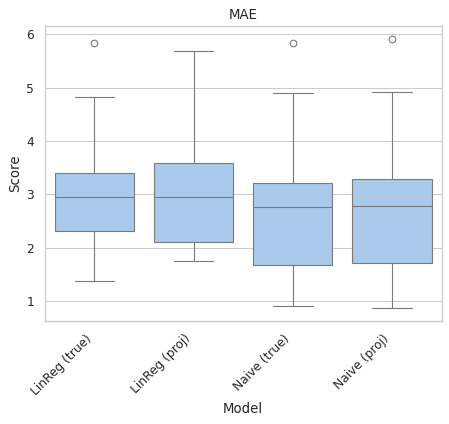

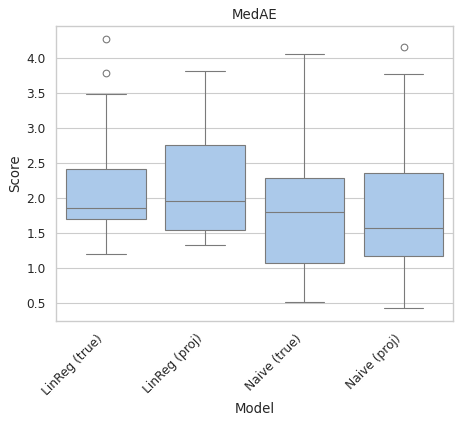

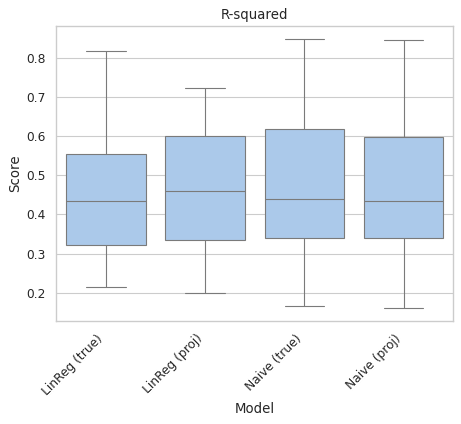

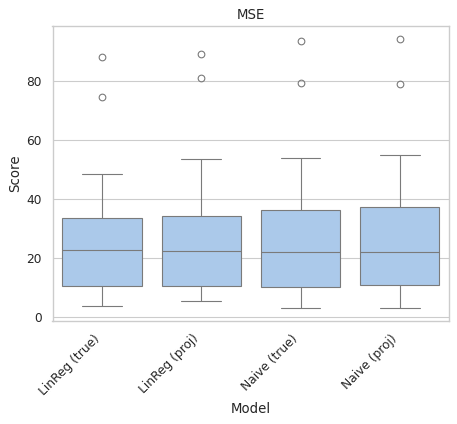

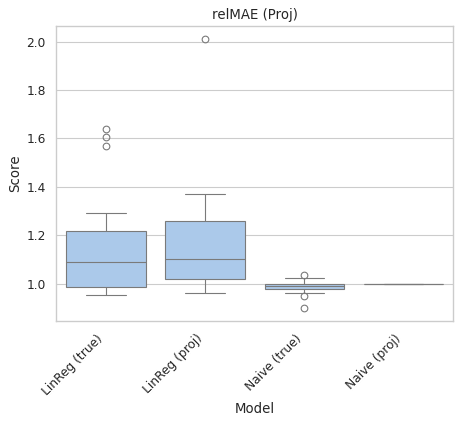

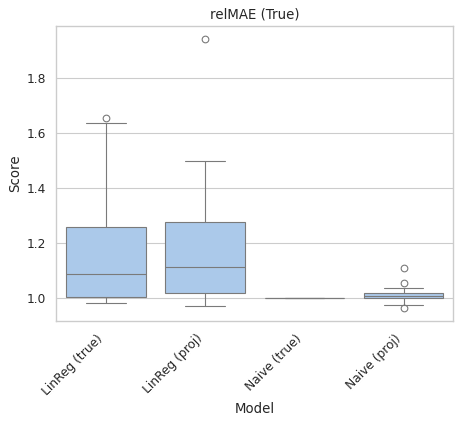

In [47]:
from epsampling.modeling import get_metrics_ser
list_run_res = []


# 'LinReg_(Naive_true_deaths_x)'
# 'LinReg_(Naive_proj_deaths_x)'


for run in df_res.Run.unique():
    subdf = df_res[df_res.Run==run]
#     for pred in ['LinReg_(True_state_inc_deaths_x)', 'LinReg_(Proj_state_inc_deaths_x)', 
#                  'Naive_true_deaths_x','Naive_proj_deaths_x',]:
    for pred in ['LinReg_(Naive_true_deaths_x)', 'LinReg_(Naive_proj_deaths_x)', 
                 'Naive_true_deaths_x','Naive_proj_deaths_x',]:
        ser = get_metrics_ser(subdf, 'True_county_inc_deaths_x', pred_col=pred)
        
        ser['Run'] = run
        list_run_res.append(ser)
        
df_run = pd.DataFrame(list_run_res)
df_run

df_melt = pd.melt(df_run, id_vars=['Model'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE (Proj)','relMAE (True)'], 
                  var_name='Metric', value_name='Score')
# df_melt['Metric'] = df_melt.Metric.apply(lambda x: f'{x}\n')

m_dict = {'LinReg_(True_state_inc_deaths_x)': 'LinReg (true)',
          'LinReg_(Proj_state_inc_deaths_x)': 'LinReg (proj)',
          'LinReg_(Naive_true_deaths_x)': 'LinReg (true)',
          'LinReg_(Naive_proj_deaths_x)': 'LinReg (proj)',
          'Naive_true_deaths_x': 'Naive (true)',
          'Naive_proj_deaths_x': 'Naive (proj)'
         }

df_melt['Model'] = df_melt.Model.apply(lambda x: m_dict[x])

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='whitegrid', palette='pastel') 

DPI = 80

for metric in df_melt.Metric.unique():
    df_plot = df_melt[df_melt.Metric==metric]
#     display(df_plot)
    sns.boxplot(df_plot, x='Model',y='Score')   
    plt.title(f'{metric}')
    plt.xticks(rotation=45,ha='right')
    plt.gcf().set_dpi(DPI)
    plt.show()

### <font color=blue> Performance across counties (by population).

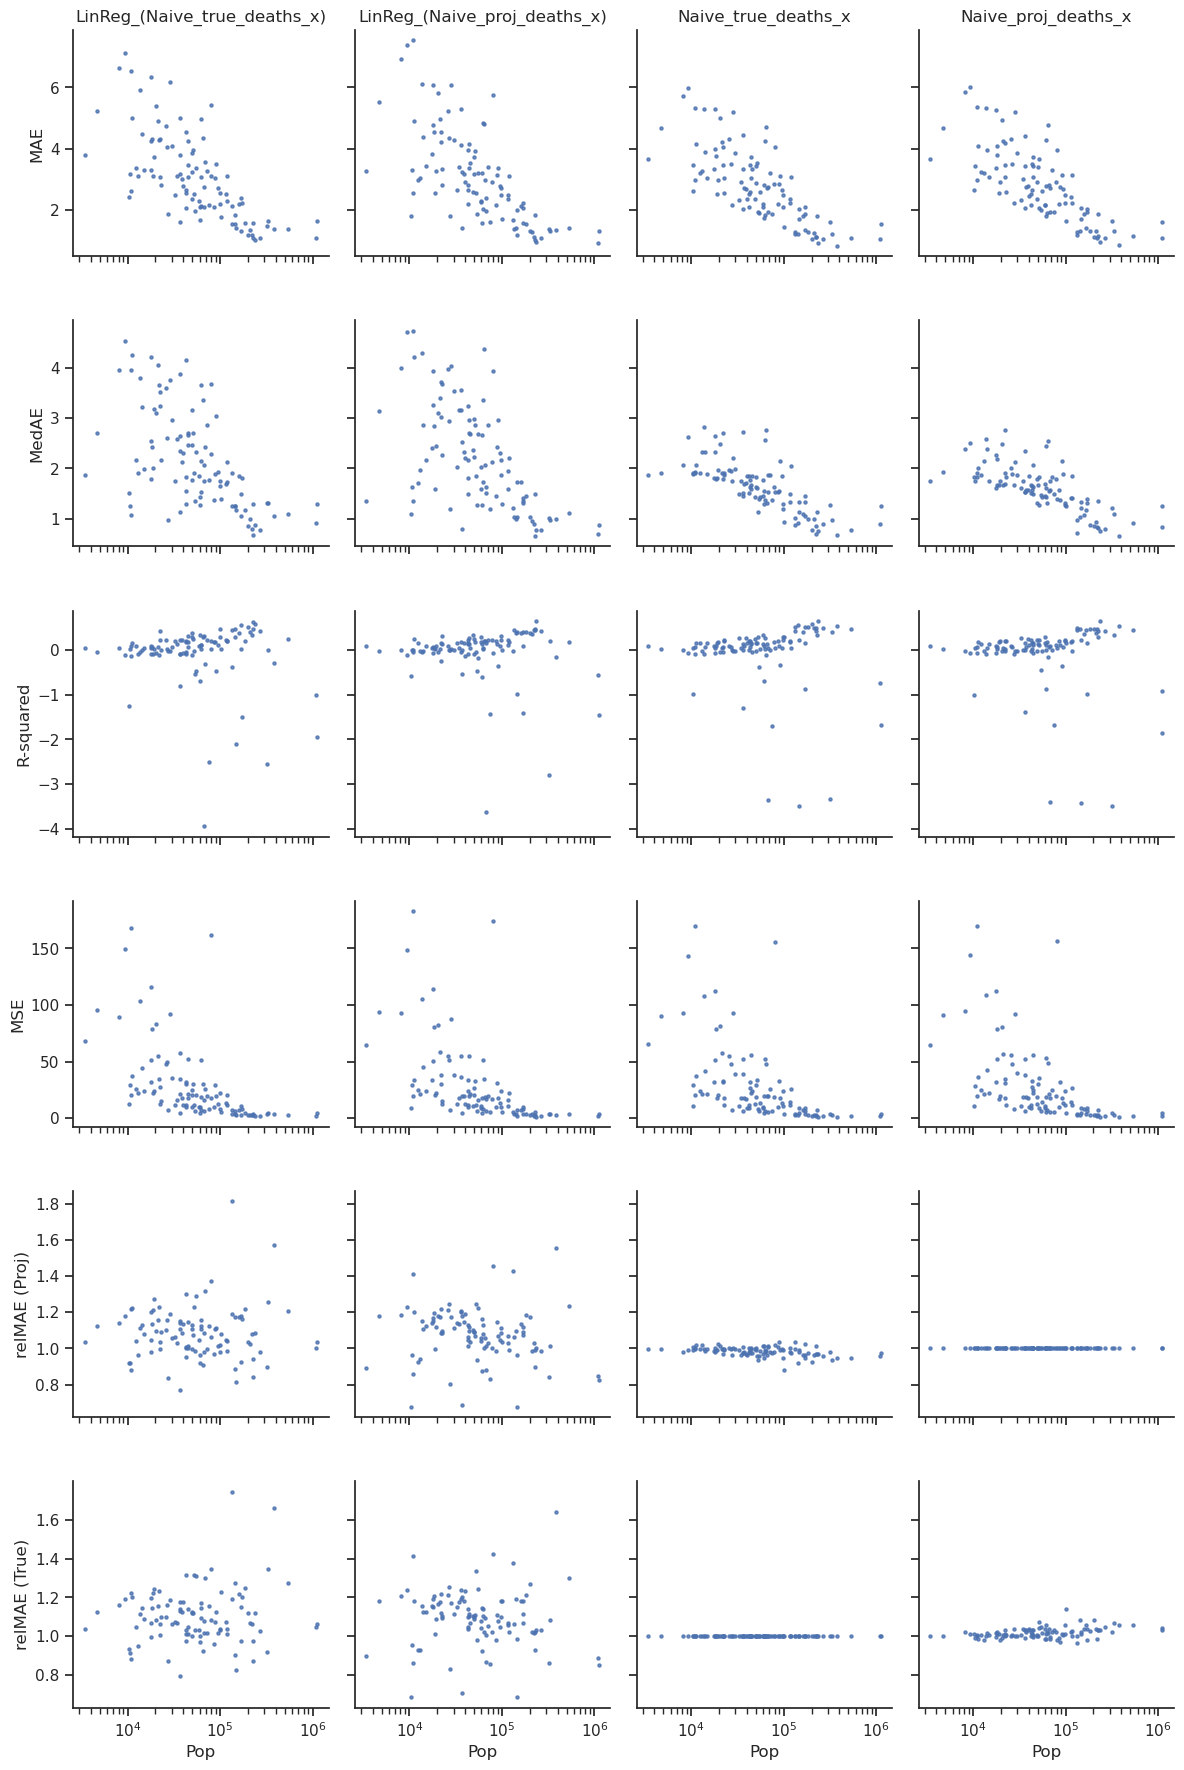

In [48]:
metrics_sers = []

# for fips in df_res.Fips.unique():
#     subdf = df_res[df_res.Fips==fips]
for fips in df_res.Fips.unique():
    subdf = df_res[df_res.Fips==fips]
#     for pred in ['LinReg_(True_state_inc_deaths_x)', 'LinReg_(Proj_state_inc_deaths_x)', 
#                  'Naive_true_deaths_x','Naive_proj_deaths_x',]:
    for pred in ['LinReg_(Naive_true_deaths_x)', 'LinReg_(Naive_proj_deaths_x)', 
                 'Naive_true_deaths_x','Naive_proj_deaths_x',]:
        ser = get_metrics_ser(subdf, 'True_county_inc_deaths_x', pred)
    
        ser['Fips'] = fips
        ser['Pop'] = subdf.Pop.values[0]
    
        metrics_sers.append(ser)
    
df_county = pd.DataFrame(metrics_sers)

df_melt = pd.melt(df_county, id_vars=['Fips','Pop','Model'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE (Proj)','relMAE (True)'], 
                  var_name='Metric', value_name='Score')
df_melt['Metric'] = df_melt.Metric.apply(lambda x: f'{x}\n')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

g = sns.FacetGrid(df_melt, col='Model', row="Metric", sharey='row') #, margin_titles=True)
g.map(plt.scatter, 'Pop','Score', alpha=0.8, s=5).set(xscale='log')
g.set_titles(col_template='{col_name}', row_template='{row_name}',)

for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip())
        else:
            axes_col.set_title('')
        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(row.strip())

plt.show()